In [1]:
from functions import *
from import_data import *

from astropy.constants import R_sun, L_sun, sigma_sb
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

In [2]:
# Import data
df_hmxb = HMXB_parameters()
df_sg_params = supergiant_stellar_parameters()
df_falenga = falenga()
df_stellar_params = stellar_params()
df_photometric_params = photometric_params()
df_BJ = BailerJones()

In [3]:
df_hmxb

,id,ST,ST_short,ruwe,period,spinperiod,luminosity,B,V,J,H,K
0,2S0114+650,B1Iae,B1I,0.944642,15.660000,10008.000000,NaN,11.99,11.14,8.597,8.296,8.107
1,SMC X-1,B0Ib,O9I,1.002890,NaN,NaN,NaN,13.00,13.15,13.445,13.513,13.474
2,LMC X-4,O8III,O8III,1.014480,1.400000,13.500000,NaN,13.90,14.00,14.586,14.780,14.750
3,Vela X-1,B0.5Ia,B0I,0.880197,0.000896,283.000000,NaN,7.37,6.87,5.833,5.705,5.596
4,Cen X-3,O9III,O9III,1.020704,2.030000,0.000048,NaN,14.40,12.27,NaN,NaN,NaN
5,GX301-2,B1.5Iaeq,B1I,0.908531,0.041500,680.000000,NaN,12.70,10.66,6.717,6.077,5.672
6,4U1538-52,B0.2Ia,B0I,0.985791,0.000037,526.420000,NaN,16.30,14.50,10.358,9.910,9.677
7,4U1700-37,O6Iafcp,O6I,0.808192,0.000003,NaN,NaN,6.78,6.51,5.744,5.639,5.496
8,4U1907+09,O8.5Iab,O8I,0.883853,0.000838,437.500000,NaN,19.41,16.35,NaN,NaN,NaN
9,LMC X-1,O8III(f)p,O8III,0.996263,3.909170,NaN,NaN,14.80,14.50,13.695,13.537,13.293


Calculate observed luminosity

In [4]:
df_L = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "L_true": [None] * len(df_hmxb['id']),
                              "L_expected": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id']),
                              "logL_true/L_sun": [None] * len(df_hmxb['id']),
                              "Teff": [None] * len(df_hmxb['id']),
                              "logTeff": [None] * len(df_hmxb['id'])})

In [5]:
df_BJ

,source_id,id,ra,ra_error,dec_error,dec,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag
0,524924310153249920,2S0114+650,19.511227,0.007461,0.008894,65.291623,4475.7110,4291.8213,4693.1070,4527.0576,4322.5547,4850.6323,10033
1,4686397666038575104,SMC X-1,19.271456,0.022771,0.021736,-73.443343,64000.0000,12747.2480,22433.6540,64000.0000,12523.1210,18382.2700,10022
2,4660300345280168192,LMC X-4,83.206501,0.021186,0.021907,-66.370332,50000.0000,13413.4000,23731.2560,50000.0000,12715.7520,17712.3980,10012
3,5620657678322625920,Vela X-1,135.528559,0.010860,0.012675,-40.554653,1960.9159,1907.9954,2018.4348,1969.4784,1901.4370,2029.5931,10033
4,5337498593446516480,Cen X-3,170.312855,0.011634,0.011172,-60.623776,6784.6416,6212.5800,7418.7820,6752.4946,6297.3564,7431.1533,10033
5,6054569565614460800,GX301-2,186.656451,0.012048,0.013341,-62.770359,3604.5767,3409.2615,3808.6685,3546.0981,3381.9048,3729.7097,10033
6,5886085557746480000,4U1538-52,235.597298,0.010905,0.009432,-52.386012,5614.2314,5179.2850,6103.2700,5535.3643,5091.0376,5887.9526,10033
7,5976382915813535232,4U1700-37,255.986566,0.021049,0.012138,-37.844120,1499.6696,1442.5804,1550.4056,1513.9932,1461.3417,1592.3752,10033
8,4309225217336733824,4U1907+09,287.404730,0.059651,0.065512,9.832011,3571.8506,2837.5386,4350.9985,3170.2651,2466.2412,3996.0024,10033
9,4657637156283982336,LMC X-1,84.911809,0.016985,0.016223,-69.743200,50000.0000,19126.4200,30727.1350,50000.0000,17369.2660,24212.5430,10022


In [6]:
for i in range(df_hmxb.shape[0]):
    # Object id
    id = df_hmxb.loc[i, 'id']

    # Spectral type of object
    spectral_type = df_hmxb.loc[i, "ST"]

    # Effective temperature based on spectral type
    Teff = interpolate(df2=df_stellar_params, spectral_type=spectral_type, quantity='Teff')

    # Based on the available filters determine the luminosity
    if math.isnan(df_hmxb.loc[i, 'B']) == False and math.isnan(df_hmxb.loc[i, 'V']) == False and id in df_BJ['id'].tolist():
        # Expected (B-V)0 of object based on spectral type
        BV0 = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='(B-V)0')

        # Observed (B-V) of object based on simbad filters
        BVobs = df_hmxb.loc[i, 'B'] - df_hmxb.loc[i, 'V']

        # Bolometric correction (BC)
        BCv = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='BCv')

        # Distance
        distance = df_BJ.loc[df_BJ['id'] == id, 'r_med_geo'].reset_index(drop=True).at[0]

        # Calculate extinction
        Av = 3.2 * (BVobs - BV0)
        if id == 'Cen X-3':
            Av = 3.2 * 1.4

        # Calculate Absulute magnitude (visual)
        Mv = df_hmxb.loc[i, 'V'] - 5 * np.log10(distance) + 5 - Av

        # Calculate bolomatric absolute magnitude
        Mbol = Mv + BCv

        # Calculate the luminosity in solar luminosities
        L = 10**((Mbol - 4.74) / (-2.5))

        # Put L in luminosity dataframe
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "L_true"] = L
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logL_true/L_sun"] = np.log10(L)
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "Teff"] = Teff
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logTeff"] = np.log10(Teff)
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "ST"] = spectral_type


    if math.isnan(df_hmxb.loc[i, 'J']) == False and math.isnan(df_hmxb.loc[i, 'H']) == False and id in df_BJ['id'].tolist():
        # Expected (B-V)0 of object based on spectral type
        JH0 = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='(J-H)0')

        # Observed (B-V) of object based on simbad filters
        JHobs = df_hmxb.loc[i, 'J'] - df_hmxb.loc[i, 'H']

        # Bolometric correction (BC)
        BCh = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='BCh')

        # Distance
        distance = df_BJ.loc[df_BJ['id'] == id, 'r_med_geo'].reset_index(drop=True).at[0]

        # Calculate extinction
        Ah = 0.46 * (JHobs - JH0)

        # Calculate Absulute magnitude (visual)
        Mh = df_hmxb.loc[i, 'H'] - 5 * np.log10(distance) + 5 - Ah

        # Calculate bolomatric absolute magnitude
        Mbol = Mh + BCh

        # Calculate the luminosity in solar luminosities
        L = 10**((Mbol - 4.74) / (-2.5))

        # Put L in luminosity dataframe
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "L_true"] = L
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logL_true/L_sun"] = np.log10(L)
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "Teff"] = Teff
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logTeff"] = np.log10(Teff)
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "ST"] = spectral_type

df_L = df_L.dropna(subset=['L_true']).reset_index(drop=True)

In [7]:
df_L

,id,L_true,L_expected,ST,logL_true/L_sun,Teff,logTeff
0,2S0114+650,186615.654406,None,B1Iae,5.270948,27748.0,4.443232
1,SMC X-1,315419.070772,None,B0Ib,5.498888,29558.0,4.470675
2,LMC X-4,79156.030773,None,O8III,4.898484,33179.0,4.520863
3,Vela X-1,393287.31227,None,B0.5Ia,5.59471,28653.0,4.45717
4,Cen X-3,408369.992216,None,O9III,5.611054,31368.0,4.496487
5,GX301-2,992906.930737,None,B1.5Iaeq,5.996909,26843.0,4.428831
6,4U1538-52,80696.11332,None,B0.2Ia,4.906853,29196.0,4.465323
7,4U1700-37,491984.222831,None,O6Iafcp,5.691951,36801.0,4.56586
8,4U1907+09,815429.784813,None,O8.5Iab,5.911387,32274.0,4.508853
9,LMC X-1,288703.473234,None,O8III(f)p,5.460452,33179.0,4.520863


Calculate observed radius

In [8]:
# Make radius dataframe
df_R = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "R_true": [None] * len(df_hmxb['id']),
                              "R_expected": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id'])})

for i in range(df_falenga.shape[0]):
    # Orbital separation
    a = df_falenga.loc[i, 'a']
    # Inclination
    inc = df_falenga.loc[i, 'i']
    # Semi eclipse angle
    theta_e = df_falenga.loc[i, 'semi_eclipse_angle']

    # Calculate Radius
    Rob = a * ((np.cos(np.deg2rad(inc)))**2 + (np.sin(np.deg2rad(inc)))**2 * (np.sin(np.deg2rad(theta_e)))**2)**(1/2)

    # Object id
    id = df_falenga.loc[i, 'id']
    # Spectral type
    spectral_type = df_hmxb[df_hmxb["id"] == str(id)]["ST"].reset_index(drop=True).at[0]

    # Put R in luminosity dataframe
    df_R.loc[df_R["id"] == id, "R_true"] = Rob
    df_R.loc[df_R["id"] == id, "ST"] = spectral_type

In [9]:
df_R

,id,R_true,R_expected,ST
0,2S0114+650,None,None,None
1,SMC X-1,16.254598,None,B0Ib
2,LMC X-4,7.975631,None,O8III
3,Vela X-1,33.847001,None,B0.5Ia
4,Cen X-3,12.094002,None,O9III
5,GX301-2,None,None,None
6,4U1538-52,11.249967,None,B0.2Ia
7,4U1700-37,23.198571,None,O6Iafcp
8,4U1907+09,None,None,None
9,LMC X-1,None,None,None


Calculate the expected radius from the Teff and the observed luminosity

In [10]:
for i in range(df_L.shape[0]):
    # id
    id = df_L.loc[i, 'id']

    # Spectral type
    spectral_type = df_L.loc[i, 'ST']

    # True luminosity
    L = df_L.loc[df_L["id"] == id, "L_true"].reset_index(drop=True).at[0]
    
    # Effective temperature from model
    Teff = interpolate(df2=df_stellar_params, spectral_type=spectral_type, quantity='Teff')

    # Calculate the radius
    R = np.sqrt((L_sun.value / R_sun.value**2) * (L / (4 * np.pi * sigma_sb.value * Teff**4)))

    # Save luminosity in dataframe
    df_R.loc[df_R['id'] == id, "R_expected"] = R
    df_R.loc[df_R['id'] == id, "ST"] = spectral_type

In [11]:
# Calculate ratio
df_R["R_expected/R_true"] = df_R["R_expected"] / df_R["R_true"]

In [12]:
df_R = df_R.dropna(subset=['R_true', 'R_expected']).reset_index(drop=True)

In [13]:
pd.merge(df_R, df_L, on='id')

,id,R_true,R_expected,ST_x,R_expected/R_true,L_true,L_expected,ST_y,logL_true/L_sun,Teff,logTeff
0,SMC X-1,16.254598,21.416428,B0Ib,1.317561,315419.070772,None,B0Ib,5.498888,29558.0,4.470675
1,LMC X-4,7.975631,8.514685,O8III,1.067588,79156.030773,None,O8III,4.898484,33179.0,4.520863
2,Vela X-1,33.847001,25.448836,B0.5Ia,0.751879,393287.31227,None,B0.5Ia,5.59471,28653.0,4.45717
3,Cen X-3,12.094002,21.637467,O9III,1.789107,408369.992216,None,O9III,5.611054,31368.0,4.496487
4,4U1538-52,11.249967,11.102806,B0.2Ia,0.986919,80696.11332,None,B0.2Ia,4.906853,29196.0,4.465323
5,4U1700-37,23.198571,17.254783,O6Iafcp,0.743786,491984.222831,None,O6Iafcp,5.691951,36801.0,4.56586
6,XTE J1855-026,23.901271,14.048012,B0Iaep,0.587752,135713.664822,None,B0Iaep,5.132624,29558.0,4.470675
7,OAO 1657-415,25.690671,2.406273,O5fpe,0.093663,11595.055009,None,O5fpe,4.064273,38612.0,4.586722


Mass

In [14]:
df_M = pd.read_excel("tables/M_expBONNSAI.xlsx")
df_M = pd.merge(df_M, df_falenga, on='id')[["id", "M_exp", "M_opt"]]
df_M["M_opt/M_exp"] = df_M["M_opt"] / df_M["M_exp"]

In [15]:
df_MRL = pd.merge(df_M, pd.merge(df_R, df_L, on='id'), on='id').drop(columns=['ST_y']).rename(columns={"ST_x": 'ST'})
df_MRL

,id,M_exp,M_opt,M_opt/M_exp,R_true,R_expected,ST,R_expected/R_true,L_true,L_expected,logL_true/L_sun,Teff,logTeff
0,SMC X-1,28.8,18.0,0.625000,16.254598,21.416428,B0Ib,1.317561,315419.070772,None,5.498888,29558.0,4.470675
1,Vela X-1,38.4,26.0,0.677083,33.847001,25.448836,B0.5Ia,0.751879,393287.31227,None,5.59471,28653.0,4.45717
2,LMC X-4,21.8,18.0,0.825688,7.975631,8.514685,O8III,1.067588,79156.030773,None,4.898484,33179.0,4.520863
3,4U1700-37,35.8,46.0,1.284916,23.198571,17.254783,O6Iafcp,0.743786,491984.222831,None,5.691951,36801.0,4.56586
4,4U1538-52,22.4,16.0,0.714286,11.249967,11.102806,B0.2Ia,0.986919,80696.11332,None,4.906853,29196.0,4.465323
5,Cen X-3,126.4,24.0,0.189873,12.094002,21.637467,O9III,1.789107,408369.992216,None,5.611054,31368.0,4.496487
6,XTE J1855-026,21.2,21.0,0.990566,23.901271,14.048012,B0Iaep,0.587752,135713.664822,None,5.132624,29558.0,4.470675
7,OAO 1657-415,8.8,17.5,1.988636,25.690671,2.406273,O5fpe,0.093663,11595.055009,None,4.064273,38612.0,4.586722


Plot

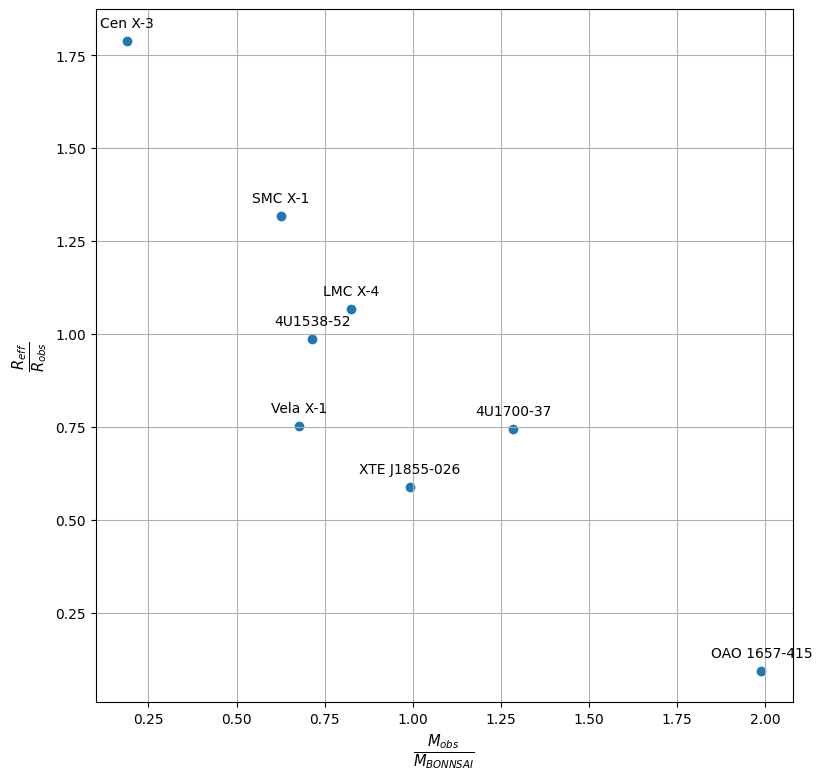

In [16]:
plt.figure(figsize=(9,9))
plt.scatter(df_MRL["M_opt/M_exp"], df_MRL["R_expected/R_true"])
# Add labels to each point
for i, label in enumerate(df_MRL["id"].tolist()):
    plt.annotate(label, (df_MRL["M_opt/M_exp"].tolist()[i], df_MRL["R_expected/R_true"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')
# plt.ylim(0.5, 2.5)
# plt.xlim(0,1.5)
plt.grid(True)
plt.xlabel(r"$\frac{M_{obs}}{M_{BONNSAI}}$", fontsize=15)
plt.ylabel(r"$\frac{R_{eff}}{R_{obs}}$", fontsize=15)
plt.show()

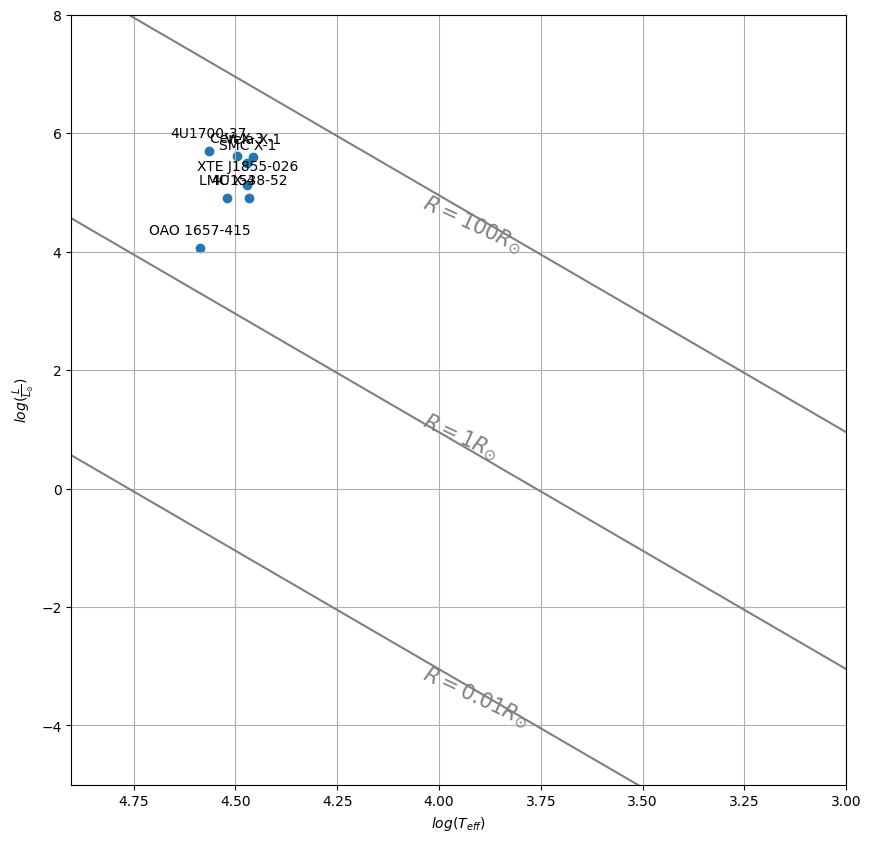

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(df_MRL["logTeff"], df_MRL["logL_true/L_sun"])
plt.ylim(-5, 8)
plt.xlim(np.log10(80000),np.log10(1000))
plt.xlabel(r"$log(T_{eff})$")
plt.ylabel(r"$log(\frac{L}{L_{\odot}})$")

def L(Teff, R):
    # Some constants
    sigma = 5.67e-8 # W m-2 k-4
    Rsun = 696340000 # m
    Lsun = 3.86e26 # W

    return np.log10((4 * np.pi * sigma * Rsun**2) / Lsun) + 2 * np.log10(R) + 4 * np.log10(Teff)

radii = [0.01, 1, 100] # Solar radii
T_cR = [10**3, 10**5]
log_T_cR = [3, 5]
L_cR = []

for R in radii:
    save = []
    for T in T_cR:
        save.append(L(T, R))
    L_cR.append(save)

for L in L_cR:
    plt.plot(log_T_cR, L, color='grey')

for i, label in enumerate(df_MRL["id"].tolist()):
    plt.annotate(label, (df_MRL["logTeff"].tolist()[i], df_MRL["logL_true/L_sun"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Add text with radii to lines
plt.text(4.05, 4, s=r'$R = 100R_{\odot}$', rotation=-25, fontsize=15, color='grey')
plt.text(4.05, 0.5, s=r'$R = 1R_{\odot}$', rotation=-25, fontsize=15, color='grey')
plt.text(4.05, -4, s=r'$R = 0.01R_{\odot}$', rotation=-25, fontsize=15, color='grey')

plt.grid(True)
plt.show()

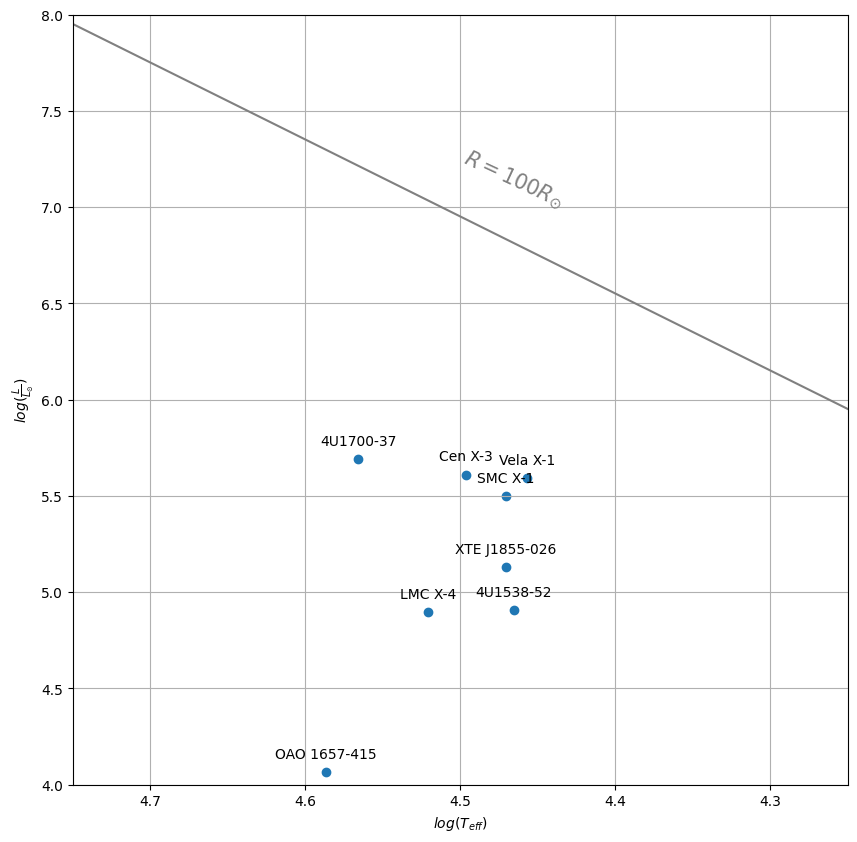

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(df_MRL["logTeff"], df_MRL["logL_true/L_sun"])
plt.ylim(4, 8)
plt.xlim(4.75,4.25)
plt.xlabel(r"$log(T_{eff})$")
plt.ylabel(r"$log(\frac{L}{L_{\odot}})$")

def L(Teff, R):
    # Some constants
    sigma = 5.67e-8 # W m-2 k-4
    Rsun = 696340000 # m
    Lsun = 3.86e26 # W

    return np.log10((4 * np.pi * sigma * Rsun**2) / Lsun) + 2 * np.log10(R) + 4 * np.log10(Teff)

radii = [0.01, 1, 100] # Solar radii
T_cR = [10**3, 10**5]
log_T_cR = [3, 5]
L_cR = []

for R in radii:
    save = []
    for T in T_cR:
        save.append(L(T, R))
    L_cR.append(save)

for L in L_cR:
    plt.plot(log_T_cR, L, color='grey')

for i, label in enumerate(df_MRL["id"].tolist()):
    plt.annotate(label, (df_MRL["logTeff"].tolist()[i], df_MRL["logL_true/L_sun"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Add text with radii to lines
plt.text(4.5, 7, s=r'$R = 100R_{\odot}$', rotation=-25, fontsize=15, color='grey')
# plt.text(4.05, 0.5, s=r'$R = 1R_{\odot}$', rotation=-25, fontsize=15, color='grey')
# plt.text(4.05, -4, s=r'$R = 0.01R_{\odot}$', rotation=-25, fontsize=15, color='grey')

plt.grid(True)
plt.show()

### Determine mass based on HRD evolutionary tracks

In [19]:
# Set the metallicity value
ZY_values = [(0.02, 0.284), (0.03, 0.302), (0.04, 0.321)]
Z = ZY_values[0][0]
Y = ZY_values[0][1]

# Set the masses for which the evolutionary tracks will be drawn
M_values = [10, 11, 12, 14, 16, 18, 20, 24, 28, 30, 35, 40, 50]
M_values = [14, 20, 24, 40, 60, 80, 120]
M_values = ['{:07.3f}'.format(m) for m in M_values]

Determine the location of the ZAMS

In [20]:
L_ZAMS, T_ZAMS = ZAMS(Z=Z, Y=Y)

Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |ev

Plot the evolutionary tracks

Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.


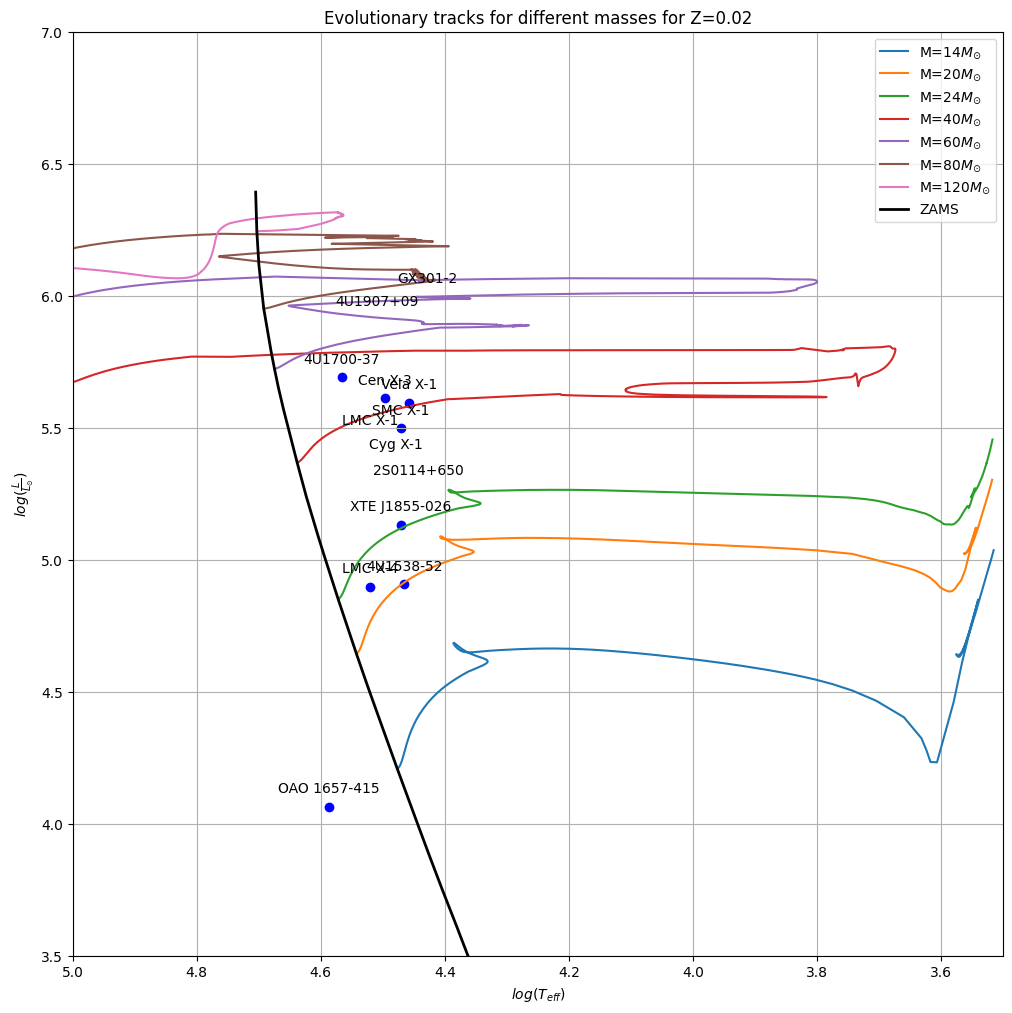

In [21]:
plt.figure(figsize=(12,12))
for M in M_values:
    df = evolutionary_track(Z=ZY_values[0][0], Y=ZY_values[0][1], M=M)

    ZAMS_index = find_ZAMS_index(df['H_CEN'].tolist())
    logL = df["LOG_L"].tolist()[ZAMS_index:]
    logT = df["LOG_TE"].tolist()[ZAMS_index:]

    logL = [float(x) for x in logL]
    logT = [float(x) for x in logT]

    plt.plot(logT, logL, label=(f'M={int(float(M))}'+r'$M_{\odot}$'))

for i, label in enumerate(df_L["id"].tolist()):
    plt.annotate(label, (df_L["logTeff"].tolist()[i], df_L["logL_true/L_sun"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.plot(T_ZAMS, L_ZAMS, label='ZAMS', color='black', linewidth=2)
plt.scatter(df_MRL['logTeff'], df_MRL['logL_true/L_sun'], color='blue')
plt.title(f'Evolutionary tracks for different masses for Z={ZY_values[0][0]}')
plt.xlabel(r"$log(T_{eff})$")
plt.ylabel(r"$log(\frac{L}{L_{\odot}})$")
plt.ylim(3.5, 7)
plt.xlim(3.5, 5)
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend()
plt.show()